In [129]:
import os
import MySQLdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger
plt.rcParams['axes.labelsize'] = 22
con = MySQLdb.connect(host="localhost",port=3306,user="mira67",passwd="1234",db="nsidcgt")

def model_test():
    #load model
    model = load_model('recent_model_m3.h5')
    SVG(model_to_dot(model).create(prog='dot', format='svg'))
    #retreive all pixels from database
    sql = 'SELECT b1,b2,b3,b4,b5,b6,b7 FROM mod500'
    df = pd.read_sql(sql, con)
    df = df.replace(-9999, 0)
    #df = minmaxscaler(df)
    data = df.as_matrix()
    X_predict = data[:,0:]
    #predict with model
    Y_predict = model.predict(X_predict)*100
    df = pd.DataFrame(Y_predict, columns=['MPF', 'IF', 'WF'])
    #record to mysql
    df.to_csv('mod500results_m3.csv', sep=',', encoding='utf-8')
    #df.to_sql(con=con, name='mod500results', if_exists='append', flavor='mysql')
    con.close()
def resVis():
    print("visualize results")
    sql = """SELECT mod500.year,mod500.month,mod500.day,mod500.qc,
    mod500.cloud,mod500res_nocloud_a.MPF,mod500res_nocloud_a.IF,mod500res_nocloud_a.WF
    FROM mod500res_nocloud_a
    LEFT JOIN mod500
    ON mod500.pid=mod500res_nocloud_a.pid"""
    df = pd.read_sql(sql, con)
    #print df.head(n=3)
    #group by year/month to compute MPF/IF/WF mean
    
    grouped = df.groupby(['year','month','day'],as_index=False)
    print("Number of Groups: ", len(grouped))
    dfmean = grouped.aggregate(np.mean)
    #print dfmean.head(n=5)
    ngroup = dfmean.groupby(['year','month','day'],as_index=False)
    #visualize trend by month for many years
    oldkey = 2000
    #yearly plot
    day = []
    mpf = []
    gn = 0
    key = 5
    fig, ax = plt.subplots()
    for key, grp in ngroup:#fix last key
        gn = gn + 1#count number of groups
        if (key[0] != oldkey) or (gn == len(ngroup)):#if year not change or last group
            ax.plot(day, mpf, label=oldkey)
            day = []
            mpf = []
            oldkey = key[0]
        #cur_day = datetime.date(int(grp['year'].as_matrix()[0]),int(grp['month'].as_matrix()[0]),int(grp['day'].as_matrix()[0]))
        cur_day = datetime.date(2000,int(grp['month'].as_matrix()[0]),int(grp['day'].as_matrix()[0]))
        day.append(cur_day)
        mpf.append(grp['MPF'].as_matrix()[0])

    ax.xaxis.set_major_formatter(yearsFmt)
    # format the ticks
    #ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    fig.autofmt_xdate()
    ax.grid(True)
    ax.legend(loc='upper right')    
    plt.show()
    
if __name__ == '__main__':
    import timeit
    print("Time flies (s): ", timeit.timeit("model_test()", setup="from __main__ import model_test", number=1))
    #print("Time flies (s): ", timeit.timeit("resVis()", setup="from __main__ import resVis", number=1))
    os.system('espeak "Congratulations, DONE!"')

Time flies (s):  204.784797907


In [133]:
#each year a plot, and calcualte a yearly mean to compare with nature
print("visualize results")
con = MySQLdb.connect(host="localhost",port=3306,user="mira67",passwd="1234",db="nsidcgt")
sql = """SELECT mod500.year,mod500.month,mod500.day,mod500.qc,
mod500.cloud, mod500.nrow, mod500.ncol, mod500res_nocloud.MPF,mod500res_nocloud.IF,mod500res_nocloud.WF
FROM mod500res_nocloud
LEFT JOIN mod500
ON mod500.pid=mod500res_nocloud.pid
WHERE mod500.month = 5 OR mod500.month = 9"""
df = pd.read_sql(sql, con)
#print df.head(n=3)
#group by year/month to compute MPF/IF/WF mean

grouped = df.groupby(['month','day','nrow','ncol'],as_index=False)
print("Number of Groups: ", len(grouped))
dfmean = grouped.aggregate(np.mean)
#print dfmean.head(n=5)
ngroup = dfmean.groupby(['month','day','nrow','ncol'],as_index=False)

visualize results
Number of Groups:  252784


In [1]:
#correlation analysis between May and Sep


Number of Groups:  154


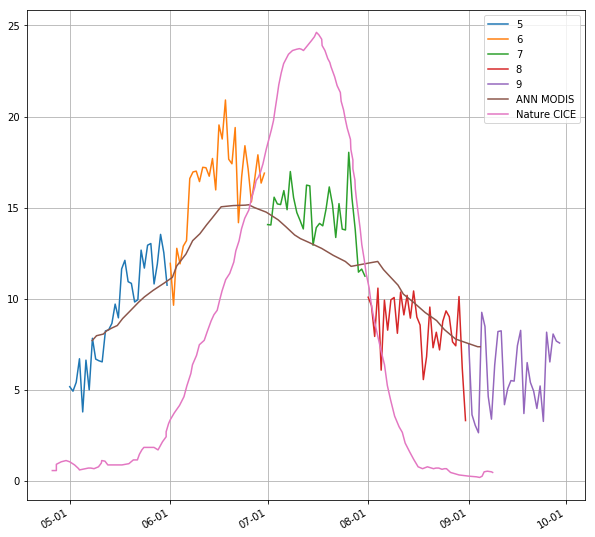

In [126]:
#daily average plot across years
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger
plt.rcParams['axes.labelsize'] = 30

import matplotlib.dates as mdates

mgrouped = df.groupby(['month','day'],as_index=False)
print("Number of Groups: ", len(mgrouped))
mdfmean = mgrouped.aggregate(np.mean)
#print dfmean.head(n=5)
mngroup = mdfmean.groupby(['month','day'],as_index=False)
#visualize trend by month for many years
oldkey = 5

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%m-%d')
day = []
mpf = []
gn = 0
fig, ax = plt.subplots()
for key, grp in mngroup:#fix last key
    gn = gn + 1#count number of groups
    if (key[0] != oldkey) or (gn == len(mngroup)):#if year not change or last group
        ax.plot(day, mpf, label=int(oldkey))
        day = []
        mpf = []
        oldkey = key[0]
    #cur_day = datetime.date(int(grp['year'].as_matrix()[0]),int(grp['month'].as_matrix()[0]),int(grp['day'].as_matrix()[0]))
    cur_day = datetime.date(1900,int(grp['month'].as_matrix()[0]),int(grp['day'].as_matrix()[0]))
    day.append(cur_day)
    mpf.append(grp['MPF'].as_matrix()[0])

ax.plot(df1['Julian Day'],df1['MPF']*100, label='ANN MODIS')
ax.plot(df2['Julian Day'],df2['MPF'], label = 'Nature CICE')
    
ax.xaxis.set_major_formatter(yearsFmt)
# format the ticks
#ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
fig.autofmt_xdate()
ax.grid(True)
ax.legend(loc='upper right')    
plt.show()

In [ ]:
#current results: no cloud only a

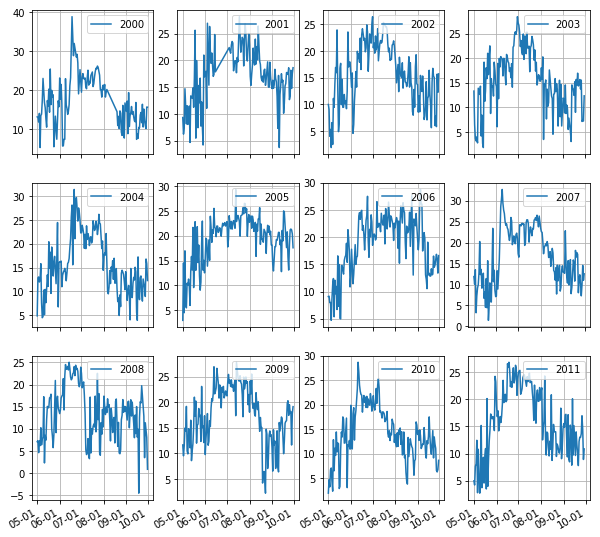

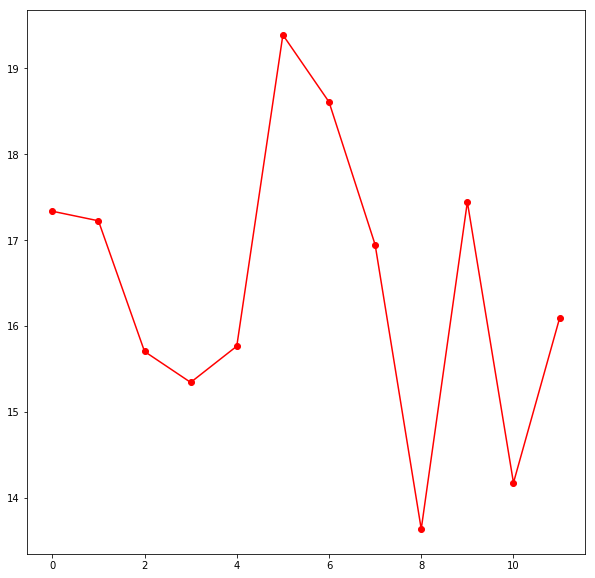

In [101]:
#visualize trend by month for many years
oldkey = 2000
#yearly plot
day = []
mpf = []
gn = 0
key = 5
pltn = 0
fig = plt.figure()

yrmean = []

for key, grp in ngroup:#fix last key
    gn = gn + 1#count number of groups
    if (key[0] != oldkey) or (gn == len(ngroup)):#if year not change or last group
        
        yrmean.append(sum(mpf)/len(mpf))
        
        pltn = pltn + 1
        ax = fig.add_subplot(3,4,pltn)
        ax.plot(day, mpf, label=int(oldkey))
        ax.xaxis.set_major_formatter(yearsFmt)
        # format the ticks
        #ax.xaxis.set_major_locator(years)
        ax.xaxis.set_major_formatter(yearsFmt)
        ax.xaxis.set_minor_locator(months)
        ax.grid(True)
        ax.legend(loc='upper right')  
        
        day = []
        mpf = []
        oldkey = key[0]
    #cur_day = datetime.date(int(grp['year'].as_matrix()[0]),int(grp['month'].as_matrix()[0]),int(grp['day'].as_matrix()[0]))
    cur_day = datetime.date(2000,int(grp['month'].as_matrix()[0]),int(grp['day'].as_matrix()[0]))
    day.append(cur_day)
    mpf.append(grp['MPF'].as_matrix()[0])  
fig.autofmt_xdate()
plt.show()

plt.figure(2)
plt.plot(yrmean,'ro-')


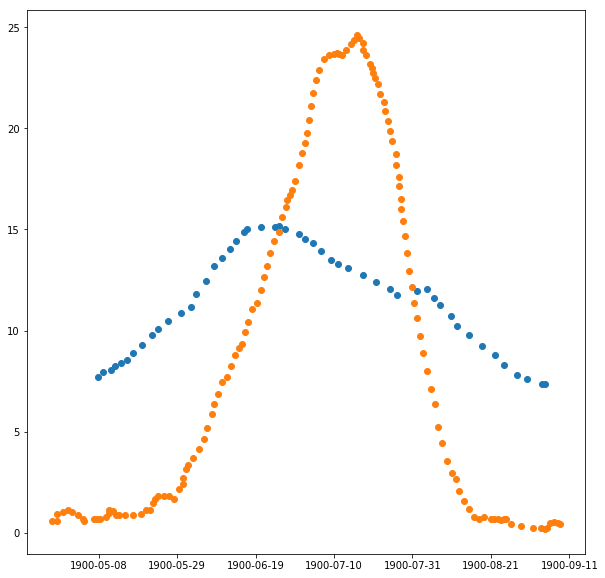

In [116]:
xl = pd.ExcelFile("figure_data.xlsx")
xl.sheet_names
df1 = xl.parse("MODIS MPF 2000-2011 mean")
df2 = xl.parse("CICE 2001-2013 mean MPF")

plt.figure()
plt.plot_date(df1['Julian Day'],df1['MPF']*100)
plt.plot_date(df2['Julian Day'],df2['MPF'])
plt.show()